In [1]:
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [2]:
import impl.layer as l

class GRU:

    def __init__(self, D, H, L, char2idx, idx2char, p_dropout):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        self.p_dropout = p_dropout
        
        # Model parameters
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        
        self.model = []
        for _ in range(self.L):
            self.model.append(m)
            
    def initial_state(self):
        return np.zeros((1, self.H))

    def dropout_forward(self, X, p_dropout):
        u = np.random.binomial(1, p_dropout, size=X.shape) / p_dropout
        # q = 1-p_dropout
        # u = np.random.binomial(1, q, size=X.shape)
        out = X * u
        cache = u
        return out, cache

    def dropout_backward(self, dout, cache):
        dX = dout * cache
        return dX
    
    def selu_forward(self, X):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        out = scale * np.where(X>=0.0, X, alpha * (np.exp(X)-1))
        cache = X
        return out, cache

    def selu_backward(self, dout, cache):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        X = cache
        dX_pos = dout.copy()
        dX_pos[X<0] = 0
        dX_neg = dout.copy()
        dX_neg[X>0] = 0
        dX = scale * np.where(X>=0.0, dX_pos, dX_neg * alpha * np.exp(X))
        return dX

    # p_dropout = keep_prob in this case! 
    # Is this true in other cases as well?
    def alpha_dropout_fwd(self, h, q):
        '''h is activation, q is keep probability: q=1-p, p=p_dropout, and q=keep_prob'''
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        alpha_p = -scale * alpha
        mask = np.random.binomial(1, q, size=h.shape)
        dropped = (mask * h) + ((1 - mask) * alpha_p)
        a = 1. / np.sqrt(q + (alpha_p ** 2 * q  * (1 - q)))
        b = -a * (1 - q) * alpha_p
        out = (a * dropped) + b
        cache = (a, mask)
        return out, cache

    def alpha_dropout_bwd(self, dout, cache):
        a, mask = cache
        d_dropped = dout * a
        dh = d_dropped * mask
        return dh
    
    def forward(self, X, h, m, train):
        Wz, Wh, Wy = m['Wz'], m['Wh'], m['Wy']
        bz, bh, by = m['bz'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        h = h_in + (hz * (hh - h_in))
        # equal to
        # h = (1.0 - hz) * h_in + hz * hh
        # or
        # h = h_in + (hz * hh)
        # or
        # h = h_in + hz
        # or
        # h = h_in + hh

        ## SELU + SELU-Dropout
        #         y, y_cache = l.fc_forward(h, Wy, by)
        #         y, y_selu_cache = self.selu_forward(y)
        #         y = X_in + y
        #         if train: # with Dropout
        #             y, y_do_cache = self.alpha_dropout_fwd(y, self.p_dropout)
        #             cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, y_selu_cache, y_do_cache)
        #         else: # no Dropout: testing or validation
        #             cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, y_selu_cache)
        
        y, y_cache = l.fc_forward(h, Wy, by)
        y = X_in + y
        
        if train: # with Dropout
            y, y_do_cache = self.dropout_forward(y, self.p_dropout)
            cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, y_do_cache)
        else: # no Dropout: testing or validation
            cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache, train):
        if train:
            h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, y_do_cache = cache
            dy = self.dropout_backward(dout=dy, cache=y_do_cache)
        else:
            h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dy_out = dy.copy()
        dh_out = dh.copy()
        
        dh, dWy, dby = l.fc_backward(dy, y_cache)
        
        dh += dh_out
        dh_in1 = dh * (1.0 - hz) # res

        dhh =  dh * hz
        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)
        
        dhz = dh * (hh - h_in)
        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)
        
        dX = dXz + dXh
        
        dh_in2 = dX[:, :self.H]
        dh = dh_in1 + dh_in2 # res cells
        
        dX = dX[:, self.H:]
        dX += dy_out # res layers

        grad = dict(Wz=dWz, Wh=dWh, Wy=dWy, bz=dbz, bh=dbh, by=dby)
        
        return dX, dh, grad
    
    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])
            
        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer], train=True)
                caches[layer].append(cache)
                X = y.copy()
            ys.append(y)
            
        return ys, caches

    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.cross_entropy(y_pred, y)
            dy = self.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            
        dXs = []
        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t], train=True)                
                for key in grad[layer].keys():
                    grads[layer][key] += grad[layer][key]
                dy = dX.copy()
            dXs.append(dX)
                
        return dXs, grads
    
    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.0
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer], train=False)
                X = y.copy()
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        # for i in range(0, X.shape[0] - minibatch_size +1, 1):
        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def adam_rnn(self, X_train, y_train, alpha, mb_size, n_iter, print_after):
        M, R = [], []
         
        # Hidden layers
        for layer in range(nn.L):
            M.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            R.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
         
        beta1 = .99
        beta2 = .999
        eps = 1e-8
        state = self.initial_state()
        smooth_loss = 1.0
        minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=False)

        # Epochs
        for iter in range(1, n_iter + 1):
            # Minibacthes
            for idx in range(len(minibatches)):
                X_mini, y_mini = minibatches[idx]
                ys, caches = self.train_forward(X_mini, state)
                loss, dys = self.loss_function(y_train=y_mini, ys=ys)
                _, grads = self.train_backward(dys, caches)
                self.losses['train'].append(loss)
                smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
                self.losses['smooth train'].append(smooth_loss)

                for layer in range(nn.L):
                    for key in grads[layer].keys(): #key, value: items
                        M[layer][key] = l.exp_running_avg(M[layer][key], grads[layer][key], beta1)
                        R[layer][key] = l.exp_running_avg(R[layer][key], grads[layer][key]**2, beta2)

                        m_k_hat = M[layer][key] / (1. - (beta1**(iter)))
                        r_k_hat = R[layer][key] / (1. - (beta2**(iter)))

                        self.model[layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

            # Print loss and test sample
            if iter % print_after == 0:
                print('Iter-{} loss: {:.4f}'.format(iter, loss))
                sample = self.test(X_mini[0], state, size=100)
                print(sample)

Iter-10 loss: 36.9298
c,td efsin tat ir lassat8snan.aric本soe, tmNhosrrog sTCthnegasJsnat8cbir4gs. ts
czredewismrRs thchcluh
Iter-20 loss: 34.9455
c int oole org euuttyennre., na ehalaeaieppiimm coa.itoinm ie abewenmwieldilde 92cetarm. igeg' 1nl um
Iter-30 loss: 34.6281
cianveossin. lish 'nciioaniolania a9 Aalad inalete in nanh mr in an in th as th mh iWe hh an 9Wtl vh 
Iter-40 loss: 31.1208
cide me, oF en, 341he aad in as niW si calonm it in as as mide nmme malas Aneana easd mn thi an c4 mo
Iter-50 loss: 30.5948
corrd dususmencithceor tany Euur% 0onnPede od, camhonthe coun,-iur osamen
asancecacaa caeit is Wontns
Iter-60 loss: 32.5569
canh pharatrr of tergdic Wimlth"t Asunvy rtatularal 4本upe, inlamintion "tittexs insa an s icos arhars
Iter-70 loss: 29.5962
c, eteb and Woald andanea end Rnsnuunecossuo caneu . in theot tenmame inttrof Jarya astanant Jinnitii
Iter-80 loss: 31.8593
cedoft Jryuntor Nokan radparc abu"%on and ninitaenr cenreacacosi
aran iR 2%soruroururou4soraoussouaru
Iter-90 

Iter-670 loss: 16.4922
caltor lareicac.,,,caracantnane a and inensiced edii o o cionnLLBj"nd )xbbIub'. %so7's' 7oao4's',omoo
Iter-680 loss: 16.7551
chesided 3本yeis. Anenes is is ivosss fiveessttstlokyi in of in nano e ieediiiapisit npoiarote irsiort
Iter-690 loss: 26.1841
capinal Ditaeany An in in Jam imon iiiipmtapethrittataroturunininia mipturIponarinnnatintna isimipome
Iter-700 loss: 21.2232
comle Incy andad painsinh sited a laiamaiopaoohioeaatariatalasadnisidissessid ined in nn is na inaaii
Iter-710 loss: 17.4326
cy. In in Ansenitrox fomtIdefe t ll 3a. m m–apipaliti, rice o iimi o iloo i f  momii%7ontiin inloiild
Iter-720 loss: 12.6625
ctl Oxdolectorcwistenopot ton in ninhes ininopmmpemorereontondrriniiinonnlobal inaroonatiurunen ciin 
Iter-730 loss: 23.2114
chesmcesmloUcos. in-mlytc. nnnnnnnninnanininman )mntot tuninar laciiiimeadedereadenotin a inae i ana 
Iter-740 loss: 16.7239
carosican he frrrco oretod-s.om. D foria ffof4ftofolofouocono Star of rton hof in anoo urof 本iciotora


Iter-1330 loss: 11.5131
contyuritationtthnteouth tntory me pi in ti%oatttn ttttttitittcititttttttoaiatootittoatcoeottoooeoooo
Iter-1340 loss: 20.9437
cdsio pilan1r on.    aaa.aamison   rn manae inananannnaiiniani inii nnnna iaiiniinii iiiiiiiiiiiiiiii
Iter-1350 loss: 10.0576
chaa citatitodyry inontorrororue inc u r mm u nninunouu neunintoonuuininiruininr sonnninnnin nryicinr
Iter-1360 loss: 17.7346
che Gltan Paten tl lawataaa ea a a c P my rn. carar te in nn nn in e n n n nan tann n nenn nand taun 
Iter-1370 loss: 18.8689
condy the souldgnscsen.iiuiuusss sssisiaic cgehol l niniiiicciol ic iiiisio ieiuiolideiodicueedecisus
Iter-1380 loss: 10.9192
ce isloupentmetentmmpmront a tiimausiaanuhiada mt mmtomd nsmm on mmmmmm mnnmmmmtirtanonnnn porinm o o
Iter-1390 loss: 23.2758
chy wraperion %s issu ouroeiororooiro ioiioioioorrteraiaiaturiiitararcisio iuiatucciruiiittt p turaar
Iter-1400 loss: 7.6820
co the aseuthe nas iana d un nen ano mama and aa aatayasa aveasan      a anan   a a a a a a a a

Iter-1990 loss: 7.3953
chanito innt tagiiosi iris m       p  m   irin stilonnlol sns s  ntt  rtss rrs rnss r sin ns s ssss t
Iter-2000 loss: 24.7273
condytmmine on tararatcenserts    sssesstst u u uryu tr t camoto o fttrrtimitafttu rr Hho f ouu tkiuu
Iter-2010 loss: 17.1884
c, isvvendurtu tdanisitar ii s isir  ss is st itt i  a     i   it iioasassitrintssettanesosissssssss 
Iter-2020 loss: 24.7681
cameyy pe pittoo opitichretccccontn   ooiio a oro e   e ia  arirt or    r  o    nih n n nioc ionn iii
Iter-2030 loss: 19.0686
cy inclanestunatunstitiint. r.sss m  u u  t k  iu  umh.  ir mm rri mimnar o irmi ui t inmnn inmnrmmmt
Iter-2040 loss: 13.6675
csy eaceoo tar  anit rirhtanshhahh hiiiie  iniee ie ii e thh t o t  rh r rhirirrr nirhicini corce  ci
Iter-2050 loss: 19.7702
cion oficeraddmtot endeo wiuit c    ctttct i  c c wcc st ccthrt titurrca crcthccc arafiniininincttnou
Iter-2060 loss: 9.3063
csidezecopered i. e ic m h romoss i mi iririiio oo r oio osiss n  o i   ir o piorichio n oorio s

Iter-2650 loss: 8.5342
checi9an tani4is a aii aneeeeo an ensseoinis  esshsgsiiinini   nss istaaissash asss tsis   iis innine
Iter-2660 loss: 15.6035
chity ith R9s stse sst  eeeee a e s t i a e a amarm aaes a as at as asmm as m ieucte      s        ss
Iter-2670 loss: 13.3572
cifemen'e inetesea ireteaeeeececerece eeres e siseeessacdransra eransesasstt r atta cn n caaaatattttt
Iter-2680 loss: 14.6587
c. Japan issss apappapateosaaataasliassa astet a sttsttt sttt istss  tnitei   i  t aniisa    s taa  t
Iter-2690 loss: 13.3851
ch, theith itiehtmiytc ceehhhhvhat3 ihahhian i ctacciiicaiiiiiiihiiiiiihiia iiiiii ia  ia a      h   
Iter-2700 loss: 16.3100
city propertocoppppreeeeroerrocitieoocor ooooperaroronrrororepteoererooerearetractcctcciochcettttictt
Iter-2710 loss: 7.4400
che inlalediss si segan sariiiiirisiiiiiosiaaiasanasaaa iii iiaia a ariiia aiaea a cos a   airia i a 
Iter-2720 loss: 6.5163
chirtlititapan ermeie andia a s ssseaid ie tere e   teeaisarai aaana a iaaaaa eaa aa ai iiii aaee

Iter-3310 loss: 8.1750
co Glded ac c aaaaalalat cftals a as c tataaaawacaattadeceeeaeaea aaaec e a eacacacaceceeaaaacfeawcaa
Iter-3320 loss: 18.6464
c Ga.vea.
uusastiss c aasss teuuaaeateaaaetaa asoauaauaartateeaasssssse uusaraseaisaar mama e rareiaa
Iter-3330 loss: 14.9692
ced'Japan sess a henssasseasa isesaiiiiiissssss ta eis asisss a ii  iis asaasaiaaass asssssassisss is
Iter-3340 loss: 7.6263
city partiip ipioiiiiee  yio  r  iii      i   i iii   iii   iii ii      t         i   e iiii  iiiiiii
Iter-3350 loss: 14.6228
ccevfe fesourefclaaaaseaaaasssssssaesisssiesssssssssssassiasisisososisssssssssssssesssssosssssaiissss
Iter-3360 loss: 8.4933
ceegto andeaeteaearse aicisssassscasacaiscnsaassacaaaacaaasssssasatasaseaaaaaraaataaaaaaaaaascaaasaea
Iter-3370 loss: 3.2450
che foulith ththcccecisirgeai.s is iis   iiiiiiiiiii   iiiii iiiii i i iii i ii  s    i i i s ii   s 
Iter-3380 loss: 16.6285
ch eacesea aalet eeeeeeerrieeeii rrp rtaia aiiiiiiiiiiiiiiiiiiiiaiaaaraiiirriinriiasaiiriiaiatttta

Iter-3970 loss: 11.8897
constototooramy tiii iim i  ittooo r iia oii o ootiiyuioii ouonoiiiio o a o tiooo ii  ouiioooio tio o
Iter-3980 loss: 15.4947
c0tit pis ind irsirde imtcsssttttttt ttciaacicatcccccctctteiticiioicnctcccccticttttaceetttiaacaiiciii
Iter-3990 loss: 6.8775
clabedexeceddedectaerdcadareesxase accdssedcdeee.deseieeere...ts..a.e rdess.r   sldas.....s r.. rrr s
Iter-4000 loss: 14.8463
colaces intate t f tattt mtttoitiiftjotttttooofftfffttoooafeejjfjttjfoae eoaaaaiiiiiatatttatttttttete
Iter-4010 loss: 22.4811
coryy of ihe  aseaceee sacsstttcitccecitccatccec ciccee ecccee e te    s ett eo. .nfststa ttttttttttt
Iter-4020 loss: 9.9292
ch incucile SanSfRNNN N NNNNshhh5  h hhreSs NN N5r r r     r     ra  iii     irr i iiirrir 5 iiriii i
Iter-4030 loss: 9.5276
coneksy birrs -hmsms   h,,h h  hhhfthhhhhhhhhhhhhsfth f ttafttthif af aif hifif fiiooooia o ff fif  f
Iter-4040 loss: 19.6086
c Gamer.s
.raraser.sassts....s..........s..s.....ss.ss.ss.sssss.ssasssss.......ss.ssss...........

Iter-4630 loss: 15.0512
ch, naciceccstterrnttrraenerrrraranrrrarnrsscrrrrrrrrr r rrre  s rnsss st racsssresssirestrararirere 
Iter-4640 loss: 25.9603
city sratioeterxtaeettatiottetceteetaieteiisieaeeaeae eattieeeieetmeteeeieaaoeaeeaeo eamaeeaeaaaeteee
Iter-4650 loss: 12.1018
cees tircesthtstseettteeetmteieettettttttotttetttttesettttttttttttttttttttttttetttttttttctttmttttmttt
Iter-4660 loss: 9.7709
came tent b menct  gtlttttttttttttttttttattttttttttttttcttttttetttttttttttttttttttttttttttttttttttttt
Iter-4670 loss: 22.5161
consmu, mou t  r tfffoohofohtthttftotoffohfftsothoofffhfffffffhhsffffftfoshosoffffotfoffffffoftfotfft
Iter-4680 loss: 15.4531
conomy, bhim mt aem iamum miathiim  om i mo  bammmm mmi  ammmm mmm mm   p    miiii mmm bom m p m m oi
Iter-4690 loss: 14.4526
cis surattortratttoo ru  eotitiaoo iiooaaiaiaoooa oooi ioii ootiaooiioai oa oio iooooaiaaaooooioooooi
Iter-4700 loss: 23.4678
can mor C9 teeoe seseeeaesraeeaiaaeeeaaaaanneeeeeeeeaaaaaeeeeedeeoeaeeeeeeeeeeeaeeaeaadeweeeaae

Iter-5290 loss: 14.8394
cons s poto m  ri t  itmtit mtiimsmtmim sssyr  ttttt   im   toit itriio m   motttteo otioommim ttm  t
Iter-5300 loss: 25.9149
cekiyy sixhy   u iiy miAuyyiyyyy y  yyy     oyy  yyyyy yy  iyyxyy  y  yy yy  y yy   yy yy iyy    yyyy
Iter-5310 loss: 8.6683
cye fivhi f t  p in g re aeeae ti  ntt  r a   r t a ia  r r itia e ia  t  a i i   e   ir   a   a  i  
Iter-5320 loss: 10.4170
chy withia cnt  i c icaetcccacalcclcccctccccccccccccmcccccccccccccccccccccccccccccccctccccmccccccccte
Iter-5330 loss: 25.6219
cted lylegestdfefssssassaaaassstlaamaaaaataaaaeaaaa sssatatsiaaassiaaaaaaaalfaaaaaaaaaaaeeacaaaaaaaaa
Iter-5340 loss: 16.0880
ch eagiseg... 1edeein   isedtdts.. tsssssssstaseaaaiastiahtssettssstttssssiatsesiitteattittttttetsse 
Iter-5350 loss: 27.6991
che forll de,,.,.,, iieeciitieeieeeeeeeeeoeeeieee.oe.i..ediiiimimmese wioffeceteeeteeeeeeeeeeeeeeeeee
Iter-5360 loss: 14.6116
contupyy fyrt .  otttttttttttttittttttt tttttttittttttttttttttttttottitttttthiittttttttiottii t

Iter-5950 loss: 22.7622
chny, mrchkenhhJnssspaiiiiias uss iiiiiuiisussiiiiiiiiiiii tussi sssiituiseeuuiaiii iiiiiapaphihshiii
Iter-5960 loss: 15.6301
canity mirte fm.....ss. mm.r..mmmmtsipbommmp.fimn..m sitmmmmotmsmt.omtmt..mte m.it.semmmo.m.o....iyrm
Iter-5970 loss: 14.7413
cyese theee ahteethhhhhhhhhhhhhhmhhhsshs mhheiiohiihe  hemmhoeh hmhessissmhhhr sheshhs mmhimhiiimmhsh
Iter-5980 loss: 12.4016
ctyvevvevgnstfeorgkhrfritrerstg, reesetetorrehri iegrrerrtermrrittetereitomltnrteriunftrrrpnfirrefmrr
Iter-5990 loss: 19.9232
cestitation sy fiih sisiissiiiiiii tiiiiiiiiiiiihisiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiimii iiiiiiiii
Iter-6000 loss: 17.5097
che filst ren iaisssssssssssst istss ssstss asssssssisssssssssisstss  ssisssssssssssssssse  sssssssst
Iter-6010 loss: 15.5281
comic lylater    ni inia aitota mt  taisiiia  itif iiiait moiiiwi iiiit aitit i   iiotiiii iaii  s  i
Iter-6020 loss: 22.7157
copits iatra ci t   m cNmtae stttatttiiii it iiii iitii ih  iiiiiiioiiiiiiii iiiiiiiiiit  ii  

Iter-6610 loss: 8.2840
conommpy imh  t u bymtitotimt o   nmun mppimimamm mmpamimomimt mamiin mmpooi m   t metim mm imom mm i
Iter-6620 loss: 14.3055
cevisians inent bn    deee       eu  ee  ess     e oed  msee e e e e e  i   oe.   d  e e e.e   r s  s
Iter-6630 loss: 26.3757
cyty aremite aaf ary fife  f tofiarsiihimvhv rytyy   l   eis e ...my h..  .ay  yy iu.    i.    yey y 
Iter-6640 loss: 13.0081
conkuyy fofototttommmommintotontttttit ooit .o mttbt.io o ao totootfttoomotthttotttmotm ttttttttttmso
Iter-6650 loss: 10.6800
consi m.o mimanhmommmm immiittimiiiimimmmitiimmmtmimtmmmiimimmmmiimmmmimimmmmmmmmmiiimiimimiiitiimimm
Iter-6660 loss: 8.8411
cytalene arir   aesaemses eabeamlsggsssgg5ppppppppppppppppppppppppppppppppppppppppppppppppppppppppppp
Iter-6670 loss: 22.8747
ceeso cexttttt th tttss. i     ctsts tttt    stsee  gstltt  t titi t t    y e . ttttottt    t si d   
Iter-6680 loss: 6.1923
cyustices I asis av t visss    s   s ds   s ts tas  s            i  v s  t Snrn Si m t  m   s   d

Iter-7270 loss: 13.2108
cina Fopal thh aah  n an m    a caa  ai     a n iiuun Jliau   iaaaaa t   s ai   thaa  ii n   aaa   ia
Iter-7280 loss: 16.0737
contiitito wutunatunymuutuiimmmmuusssmmomummmusstttimorsssitommtthssiitit iutissttssst ratoosssytsmom
Iter-7290 loss: 19.3032
can 1yonakelew ilee al  aa oelaieeet e ae ee  e eeleeleieeechecieeeteo ieweealetie aeeaeeleeeeoeeeeci
Iter-7300 loss: 13.1617
cal litircen myimtmtmmmmettitttttmetmm.  mttimi.om teammmmmmt.y.tt. .iaimutmmmmmmtm yiot miil     iii
Iter-7310 loss: 8.3150
csunciariss int auriuuu hruisslirtssthus s  ins s reto iii auos.iildsuiiasio iii s  isssi   iir. ii. 
Iter-7320 loss: 15.1180
cines a me ee iise rraeae paaaaai aiaaaaaiipiiaaiiaaaiaaaaaesiaaaaaiaaaeiiaea ain ppapaa a aeaiaaaiei
Iter-7330 loss: 20.8061
conitomm ben myuttuto y..ym................. y y.. . . sy.  tt. .... .m m   Dettttot te ttt ttotttttt
Iter-7340 loss: 12.8076
cionto, mimothmmbububotumthuyouooo tohitomom.b b.mmmmutytbhou tt.ommbosy...mbmh.t.t obobupooomo

Iter-7930 loss: 15.5923
con met mmnomyss uth tttoommumm ioiinsy mb mmo bitotiriitminounommmiibrmmmmyyyyymomyimimi ymytomy ymi
Iter-7940 loss: 20.8129
ce plarly fursumf behtpmmkie rtr ptch fir cethrfsftfsro  ttttt    c m ssssss roulim  r rimuturte bril
Iter-7950 loss: 9.5108
camat tarteariwmgn s ...f tso eee1       teeeee         eeo       tetet  et   steeeee  tteet eeteeett
Iter-7960 loss: 11.4076
cd eallarlamen gl wtnseettthehtttttttt tcmtmithmcctthtatathttttttthmtttatthtcnhtttttcmttttttttttttatt
Iter-7970 loss: 13.1477
chuslal fit lgmts.eassiesmtesmmmmmmmmm.t.mmm.mmmmmmtmsmtm.mmmmme...m.mamtmgmemmmmmtmmlmmm.m.mmmsmes..
Iter-7980 loss: 33.7838
ce pivn frrtlndeereahlemfssslslhtftdoulala eeeccaeclneeeeeeeeeeeeeeaaalloeeeeilea soiteeeeeeeeeie h e
Iter-7990 loss: 21.0069
c Gm
ned arans.aeramumamamammma..mamam.mmamamamumamammmu.am.e.a...m.amammmmmeae..mmmmmam.au.mmamm.m.e
Iter-8000 loss: 21.5099
ccestivesifurfems arfenfmmemmmetffsfeeettaammotthhmattthtsmhtttatntttthtttttttttttattttttttttaa

Iter-8590 loss: 10.2346
ced 2onouifhnt il,iieeiet.....inmme.mioeeemmmotmm...mtt.umiiiiiim.t..e.tee...m....en.. m. iii.   oe i
Iter-8600 loss: 17.6566
ced eevandurss  ii  .   i iii . m  h..iig hhiii i ihiiihhiiih. .  hmh    iiii   .    .ht  h. . i. r  
Iter-8610 loss: 12.9220
conitiyiryyu. ytrytymyrrny.tyitsttttturummtututitotititututytut.tytamymymytytymimytitytitynommmymitit
Iter-8620 loss: 7.2495
chenperesy rtrthtssp thWhp putglam.uur. ammueseeruta gmmmmsllst.mtusselllts..ss..tt.tt  tsasatssss et
Iter-8630 loss: 13.4699
c Ganess
.
%eees....... .....s...e.stamssttee.etteataaaassstttttmtttttttttttttttttttttttttttttttttttt
Iter-8640 loss: 9.2791
che hegtutstts1itttteiiiiiii etttttttiiiiteetiiitiittitttttiittiieiiieie itteettttiiietttetttiittittt
Iter-8650 loss: 9.6407
ches ist euiuusteteettus  fueasaatttttite ctetetattstunuctieumucccessssesufitisssssssesuuttetttotccss
Iter-8660 loss: 26.3123
cd,nd farstansoo.eeceeee eeee cieaetttttiatttt tttttesaossr siiefiitttttt ettttssitittttiiteitttt

Iter-9250 loss: 22.8043
chukcan the mlamaure mer.rsmmttmm.mmmmemurum mm.mmmm.tummmmmemmummm.mmemmthmmmm.t.s.m.m.u.m.m.mamrm.m
Iter-9260 loss: 16.8491
chmintcectar frkalsdortrer.rtttrrrtslrerslarlnorostsrl.rertt.mermrmmlmlnsrcn mmrmmmmmrlmmrallmmmissrs
Iter-9270 loss: 13.8175
c Gamal.
ase mteae.teeemttestea.raseaeeetaapmt.seseammmeameteatesse.etmpea.tttmpeamesmeeetttath.e.eat
Iter-9280 loss: 12.5298
chmprn Hasestnmumtomtmettterottmtreoiemmtnmenommtepetttattthtorot mteottttthlmtetb...utotttte..attttt
Iter-9290 loss: 8.5586
cal wid alelemm wiitttttttttttttttttttit iitttteetttiiitt.tteetttiiie ttittiiiiiiiiitetciiitttitttite
Iter-9300 loss: 15.6062
contiom. botibin paarpimmsis iaismappmoap pet pittoii tissseopotstiiiioieeiitr taaiiiaiesiitom ttte i
Iter-9310 loss: 16.8103
citsriona faronmpdrradattrorglpnytotorsaaronsie mssssrlarerormrrrilynolarhrtoransrtomoitsarhl.alllola
Iter-9320 loss: 13.0356
citulapiae parirtur.r.tt s ee  eeaacimo etipaesta.aiattertpimtetimittmteamoiartariltpiprmtratte

Iter-9910 loss: 30.0892
ch andss 2etiiateiiiiiitiieaaatiiiiiiiaeaiiaimiiitiaa aaiaaeaaaa  iieaaiiiiaaaataaaaaaeeeaiii iie iti
Iter-9920 loss: 14.0381
c1mesetutamurglmerbatolgsamersrtalgmirolauttttttarulaenturarslurel.lgeralllaluturertaammttamersrimuma
Iter-9930 loss: 11.8801
cclak Hevumsr mmor.ltttt.rtit er ele . uteeamn e.eererme u er emr m..olr p r a t.ter mmree.  rererete
Iter-9940 loss: 24.3733
cdex laxpx larllaesm tmr.mttumttiteoitirimotrtttittitctttootitoeamttin ctturtitmdiitt tinteleerthettm
Iter-9950 loss: 9.1781
c Geases..sss..s.amttetessattaatseatattatetaesaatettt.eaeamettttatattt.ttttttmaeaaaaatttattteeaeasat.
Iter-9960 loss: 18.8826
camg of tletttataaaaaaaeeeaaaaaaaaaaaaaaaaaaaaaaaaaaaaataaaaaaaacaaaaaaoaeoeeeeoaaataaaaaaaataoaaaiae
Iter-9970 loss: 12.3177
curesa ge aertheitiioeitrmeroetusmttaemiiinoreurureeuuerie.ttnmieeriieihrmeta  euiiruaiinilrni rrisio
Iter-9980 loss: 13.5779
cyn oftin ou Ilspnn...lamptttrt trrrttslnmmt tttlrlmttmcpttlinirrrtttttmttr rtssttttlllrlitttpm

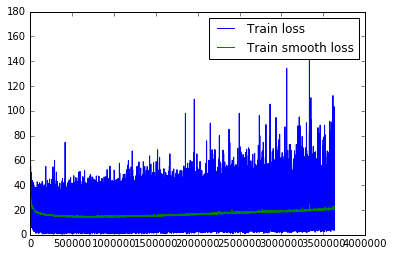

In [3]:
# Hyper-parameters
time_step = 10 # width, minibatch size and test sample size as well
num_layers = 10 # depth
n_iter = 10000 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = 10 # n_iter//100 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
nn = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, p_dropout=p_dropout, char2idx=char_to_idx, idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
nn.adam_rnn(X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()